# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [12]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.Attack_Tag,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [13]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'
def addfeature_url(df):
    url=[]
    for i in df["request.url"]:
        if "SELECT" in i or "select" in i:
            url.append("mal")
        elif "OR%20" in i or "or%20" in i:
            url.append("mal")
        elif "%20" in i:
            url.append("mal")
        elif "/../" in i:
            url.append("mal")
        elif ".__" in i:
            url.append("mal")
        elif "import" in i:
            url.append("mal")
        elif "script" in i:
            url.append("mal")
        else:
            url.append("None")
    df['url'] = url
        
#add new feature
def addfeature_Cookie(df):
    mal_co=[]
    for i in df["request.headers.Set-Cookie"]:
        if "${" in i:
            mal_co.append("mal")
        else:
            mal_co.append("None")
    df['mal_co'] = mal_co
    
def addfeature_Sec_Fetch_Site(df):    
    mal_sec=[]
    for i in df["request.headers.Sec-Fetch-Site"]:
        if "${" in i:
            mal_sec.append("mal")
        else:
            mal_sec.append("None")
    df['mal_set'] = mal_sec
    
def addfeature_Encoding(df):    
    mal_Encoding=[]
    for i in df["request.headers.Accept-Encoding"]:
        if "${" in i:
            mal_Encoding.append("mal")
        else:
            mal_Encoding.append("None")
    df['mal_Encoding'] = mal_Encoding
    
def addfeature_Sec_Fetch_Mode(df):
    Fetch_Mode=[]
    for i in df["request.headers.Sec-Fetch-Mode"]:
        if "${" in i:
            Fetch_Mode.append("mal")
        else:
            Fetch_Mode.append("None")
    df['Fetch_Mode'] = Fetch_Mode
    
def addfeature_Sec_Fetch_Dest(df):
    Fetch_Dest=[]
    for i in df["request.headers.Sec-Fetch-Dest"]:
        if "${" in i:
            Fetch_Dest.append("mal")
        else:
            Fetch_Dest.append("None")
    df['Fetch_Dest'] = Fetch_Dest
    
# After finishing the arrangements we delete the irrelevant column
df['label'] = df.apply(lambda row: categorize(row), axis=1)
addfeature_url(df)
addfeature_Cookie(df)
addfeature_Sec_Fetch_Site(df)
addfeature_Encoding(df)
addfeature_Sec_Fetch_Mode(df)
addfeature_Sec_Fetch_Dest(df)
df.drop('request.Attack_Tag', axis=1, inplace=True)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label,url,mal_co,mal_set,mal_Encoding,Fetch_Mode,Fetch_Dest
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=ubWnuAa4wIHnDTz0Su8AYWJAM7fUMCps6AxyNzFok...,"Fri, 11 Nov 2022 02:57:49 GMT",GET,http://127.0.0.1:5000/orders/get/employee_id/5482,,404 NOT FOUND,application/json,39,404,"{""error"": ""Employee ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
127496,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=SkLWkaUE83sP38c3kf-XYBCKlSlSmBTQSEJw6EaMg...,"Fri, 11 Nov 2022 02:56:21 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
127497,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=giYaDJkC2Oa-rCmlAvYglQzy_Em-YHTv_5aOjposX...,"Fri, 11 Nov 2022 02:49:37 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=

In [14]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    print(column)
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')

    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

# df

response.headers.Location
request.headers.Cookie
request.headers.Content-Length
response.headers.Set-Cookie


In [15]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings that you use for count vectorizer will go here 
SIMPLE_HEADERS = [
                  'request.method',
                  'request.headers.Accept-Language',
                  'response.status',
                  'url',
                  'mal_co',
                  'mal_set',
                  'mal_Encoding',
                  'Fetch_Mode',
                  'Fetch_Dest'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'response.headers.Content-Type',
                    'response.body',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                  ]

COLUMNS_TO_REMOVE = ['request.body',
                     'request.headers.Accept-Encoding',
                     'request.url',
                     'request.headers.Sec-Fetch-Site',
                     'request.headers.Sec-Fetch-Mode',
                     'request.headers.Sec-Fetch-Dest',
                     'request.headers.Content-Length',
                     'request.headers.Set-Cookie',
                     'response.headers.Location',
                     'request.headers.Host',
                     'request.headers.Accept',
                     'request.headers.Sec-Fetch-User',
                     'request.headers.Connection',
                     'response.headers.Content-Length',
                     'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #encode to 0 or 1
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)
# just send in all your docs here 
# On these headers we will run a "simple" BOW
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)

df



,request.headers.User-Agent,request.headers.Accept-Language,request.method,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label,url,mal_co,mal_set,mal_Encoding,Fetch_Mode,Fetch_Dest
0,-0.755929,1,0,4,-1.0,404,0.408248,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
1,0.000000,3,0,0,-1.0,200,0.956183,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
2,-0.408248,1,0,0,-1.0,200,-0.255551,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
3,0.666667,2,0,4,-1.0,404,0.408248,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
4,-0.471405,3,0,4,-1.0,404,0.894427,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,0.000000,2,0,4,-1.0,404,0.447214,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
127496,-0.471405,0,0,0,-1.0,200,0.408248,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
127497,0.000000,0,0,0,-1.0,200,0.408248,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0
127498,-0.800000,1,0,4,-1.0,404,0.000000,-1.0,-1.0,Benign,Benign,0,0,0,0,0,0


In [16]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.User-Agent       127500 non-null  float64
 1   request.headers.Accept-Language  127500 non-null  int32  
 2   request.method                   127500 non-null  int32  
 3   response.status                  127500 non-null  int32  
 4   response.headers.Content-Type    127500 non-null  float64
 5   response.status_code             127500 non-null  int64  
 6   response.body                    127500 non-null  float64
 7   request.headers.Cookie           127500 non-null  float64
 8   response.headers.Set-Cookie      127500 non-null  float64
 9   attack_type                      127500 non-null  object 
 10  label                            127500 non-null  object 
 11  url                              127500 non-null  int32  
 12  ma

In [17]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Language', 'request.method', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'request.headers.Cookie', 'response.headers.Set-Cookie', 'url', 'mal_co', 'mal_set', 'mal_Encoding', 'Fetch_Mode', 'Fetch_Dest']


request.headers.User-Agent         float64
request.headers.Accept-Language      int32
request.method                       int32
response.status                      int32
response.headers.Content-Type      float64
response.status_code                 int64
response.body                      float64
request.headers.Cookie             float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
url                                  int32
mal_co                               int32
mal_set                              int32
mal_Encoding                         int32
Fetch_Mode                           int32
Fetch_Dest                           int32
dtype: object

## Train test split

In [18]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 15) (104996,)
(22504, 15) (22504,)


Counter({'Benign': 117914, 'Malware': 9586})

## Model choosing and fitting

In [19]:
from sklearn.neighbors import NearestCentroid
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=50)
treeMachine = tree.DecisionTreeClassifier()
neigh = KNeighborsClassifier(n_neighbors=5)
# Train Model
clf.fit(X_train, y_train)
treeMachine.fit(X_train, y_train)
neigh.fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


## Result printout

              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     20812
     Malware    1.00000   1.00000   1.00000      1692

    accuracy                        1.00000     22504
   macro avg    1.00000   1.00000   1.00000     22504
weighted avg    1.00000   1.00000   1.00000     22504



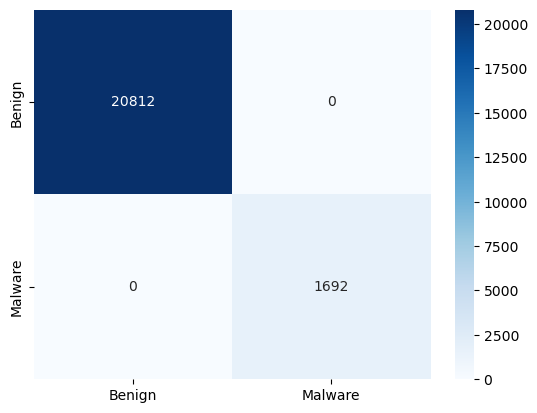

In [20]:
import statistics
predictions= clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [22]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)
# This loop iterates over all of the column names which are all NaN
for column in test_df.columns[test_df.isna().any()].tolist():
    print(column)
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
addfeature_url(test_df)
addfeature_Cookie(test_df)
addfeature_Sec_Fetch_Site(test_df)
addfeature_Encoding(test_df)
addfeature_Sec_Fetch_Mode(test_df)
addfeature_Sec_Fetch_Dest(test_df)
# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

request.headers.Cookie
request.headers.Content-Length
response.headers.Location
response.headers.Set-Cookie


# Save your predictions

In [23]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')